# Figure 6: Plot attention weights entropy.

In an independent foraging setting, attentions should.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch_geometric.data import Batch, Data, DataLoader
from itertools import product
import pandas as pd
import seaborn as sns

In [3]:
from collab_env.data.file_utils import expand_path, get_project_root

In [4]:
from collab_env.gnn.gnn import get_adjcency_from_debug_batch
from collab_env.gnn.plotting_utility import load_various_data, load_rollout
from scipy.stats import entropy

import starbars
from scipy.stats import ranksums

## Data

In [5]:
self_loops = True # TOC added 111225 10:48AM
relative_positions = False

In [6]:
data_names = ['boid_food_basic', 'boid_food_independent','boid_food_strong'] #'runpod/boid_single_species_basic']

# set short versions of dataset names
data_names_short = {}
data_names_short['boid_single_species_independent'] = 'idpnt'
data_names_short['boid_single_species_basic'] = 'boid'
data_names_short['boid_food_basic'] = 'foodbasic'
data_names_short['boid_food_independent'] = 'foodidpnt'
data_names_short['boid_food_strong'] = 'foodstrong'

### manual input model, result from model selection

In [34]:
ablation = 0
all_combinations = [
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 2, ablation),
    ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 0, ablation),
    ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 1, ablation),
    ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 2, ablation),
    ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 3, ablation),
    ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 4, ablation),
    ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 5, ablation),
    ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 6, ablation),
    #('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 6, ablation),
    #('boid_food_strong', 'vpluspplus_a', 0, 1, 0.1, 8, ablation)
    ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 7, ablation),
    ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 8, ablation),
    ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 9, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 0, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 1, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 2, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 3, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 4, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 5, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 6, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 7, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 8, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 9, ablation),    
    # ('boid_food_basic', 'vpluspplus_a', 0.005, 1, 0.5, 2, ablation),
    # or ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 0, ablation)
    #    if considering the noised version of the best seed that performed well noiseless
    #    results are the same
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.5, 2, ablation),
    # ('boid_food_strong', 'vpluspplus_a', 0.005, 1, 0.5, 2, ablation)
]

In [35]:
print('all combos ', all_combinations)

all combos  [('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 0, 0), ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 1, 0), ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 2, 0), ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 3, 0), ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 4, 0), ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 5, 0), ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 6, 0), ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 7, 0), ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 8, 0), ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 9, 0)]


In [36]:
rollout_error = None
models_to_consider = [0,1,2] #range(20) #[0, 1, 2, 3]

In [37]:
rollout_results =  {}

model_names = {}
for ind in range(len(all_combinations)):

    data_name, model_name, n, h, vr, s, ablation = all_combinations[ind]

    print("ablation ", ablation)

    #if ablation:
    #    old_format = True
    #else:
    old_format = False
    spec = {
        "data_name": data_name,
        "head": h,
        "visual_range": vr,
        "seed": s,
        "rollout_starting_frame": 5,
        "noise": n,
        "seed": s,
        "old_format": old_format,
        "ablate": ablation,
        "self_loops": self_loops,
        "use_relative_positions": relative_positions, 
    }
    
    data_name_short = data_names_short[data_name]
    if ablation:
        model_save_name = f"{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}{'_selfloops' if self_loops else ''}_ablation"
    else:
        model_save_name = f"{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}{'_selfloops' if self_loops else ''}"

    
    #try:
        
    rollout_results[ind] = load_rollout(
            "vpluspplus_a", **spec)
    model_names[ind] = model_save_name
    print(f"{ind}, Successfully import {model_save_name}")
    #except:
    #    print(f"Cannot import {model_save_name}")


ablation  0
0, Successfully import foodbasic_
n0_h1_vr0.1_s0_selfloops
ablation  0
1, Successfully import foodbasic_
n0_h1_vr0.1_s1_selfloops
ablation  0
2, Successfully import foodbasic_
n0_h1_vr0.1_s2_selfloops
ablation  0
3, Successfully import foodbasic_
n0_h1_vr0.1_s3_selfloops
ablation  0
4, Successfully import foodbasic_
n0_h1_vr0.1_s4_selfloops
ablation  0
5, Successfully import foodbasic_
n0_h1_vr0.1_s5_selfloops
ablation  0
6, Successfully import foodbasic_
n0_h1_vr0.1_s6_selfloops
ablation  0
7, Successfully import foodbasic_
n0_h1_vr0.1_s7_selfloops
ablation  0
8, Successfully import foodbasic_
n0_h1_vr0.1_s8_selfloops
ablation  0
9, Successfully import foodbasic_
n0_h1_vr0.1_s9_selfloops


In [38]:
datasets = load_various_data(data_names, 1, return_dict = True)

In [39]:
datasets.keys()

dict_keys(['boid_food_basic', 'boid_food_independent', 'boid_food_strong'])

## Parse adjacency matrix

In [40]:
models_to_consider = rollout_results.keys()
print(models_to_consider)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [41]:
print(model_names)
assert len(model_names) == len(rollout_results.keys())

{0: 'foodbasic_\nn0_h1_vr0.1_s0_selfloops', 1: 'foodbasic_\nn0_h1_vr0.1_s1_selfloops', 2: 'foodbasic_\nn0_h1_vr0.1_s2_selfloops', 3: 'foodbasic_\nn0_h1_vr0.1_s3_selfloops', 4: 'foodbasic_\nn0_h1_vr0.1_s4_selfloops', 5: 'foodbasic_\nn0_h1_vr0.1_s5_selfloops', 6: 'foodbasic_\nn0_h1_vr0.1_s6_selfloops', 7: 'foodbasic_\nn0_h1_vr0.1_s7_selfloops', 8: 'foodbasic_\nn0_h1_vr0.1_s8_selfloops', 9: 'foodbasic_\nn0_h1_vr0.1_s9_selfloops'}


In [42]:
# creating a dictionary with one specific color per group:

my_pal = {}
for m in rollout_results:

    dataname, model_name, n, h, vr, s,_ = all_combinations[m]
    d = data_names_short[dataname]
    print(d)
    if 'idpnt' in d:
        my_pal[m] = "C1"
    elif 'strong' in d:
        my_pal[m] = "C2"
    else:
        my_pal[m] = "C0"

foodbasic
foodbasic
foodbasic
foodbasic
foodbasic
foodbasic
foodbasic
foodbasic
foodbasic
foodbasic


In [43]:
#ticklabels = [model_names[c] if isinstance(c, int) else c + '\ndata' for c in entropy_dict]
ticklabels = [a[0] for a in all_combinations]
print(ticklabels)

['boid_food_basic', 'boid_food_basic', 'boid_food_basic', 'boid_food_basic', 'boid_food_basic', 'boid_food_basic', 'boid_food_basic', 'boid_food_basic', 'boid_food_basic', 'boid_food_basic']


## Plot attention adjacency matrix entries

In [44]:
def return_food_location(species_configs):
    # find food location
    width = species_configs["A"]['width']
    height = species_configs["A"]['height']
    
    food_config = species_configs["food0"]
    x, y = food_config['x']/width, food_config['y']/height

    return [x, y]

In [45]:
def find_boids_close_to_food(food_loc, predicted_xy, species_configs):
    width = species_configs["A"]['width']
    food_visual_range = species_configs['A']["food_visual_range"]
    food_eating_range = species_configs['A']["food_eating_range"]

    dis = np.sqrt(np.sum((predicted_xy - np.array(food_loc).reshape((1,2))) ** 2, axis = 1))

    condition1 = dis <= food_visual_range/width
    condition2 = dis > food_eating_range/width
    
    return np.logical_and(condition1, condition2)

In [ ]:
def figure_data_D(rollout_results, datasets, all_combinations, m_x, W, start_frame = 3, start = 0, end = 50):
    """
    example: m_x, m_y = ['boid_single_species_basic', 'boid_single_species_independent']
    
    TO DO: 
    1 - compare difference between boid-boid and boid-food attention weights instead of trying to eyeball the mean plots
    
    
    """

    dataname, model_name, n, h, vr, s, _ = all_combinations[m_x]
    dataloader = datasets[dataname]["test_loader"]
    
    _, species = list(dataloader)[0]
    all_bird_ind = species.ravel() == 0 #exclude food/environmental factor
    food_ind = species.ravel() == 1 #food
    #print(food_ind)

    batch_size = rollout_results[0][0]['actual'][0].shape[0]


    if "food" in dataname:
        species_configs = datasets[data_name]["species_configs"]
        food_loc = return_food_location(species_configs)

    entropy_x_all, sum_bird_x_all, sum_food_x_all, sum_bird_diag_all, sum_bird_diag_close_all = [], [], [], [], []
    start_ = start - start_frame
    end_ = start_ + end - start
    # print('keys ', W[0].keys())
    for file in W[0].keys():

        entropy_x_file = []
        sum_bird_x_file = []
        sum_bird_diag_file = []
        sum_bird_diag_close_file = []
        sum_food_x_file = []
        
        batch = int(np.floor(file/batch_size))
        file_within_batch = file % batch_size
        
        for frame in range(start, end):#range(len(models[m_x]["W_output"][0][file])):
            if "food" in dataname:
                predicted = rollout_results[0][batch]['predicted'][frame + start_frame][file_within_batch].squeeze()
                # restrict to the moments when boids can see food
                # so the adjacency matrix entries can have both nonzero boid and food elements.
                # suggested by Dima
                bird_ind = find_boids_close_to_food(food_loc, predicted, species_configs)
    
            else:
                bird_ind = all_bird_ind
            
            # print('bird ind: ', bird_ind)
            # print('all_bird_ind: ', all_bird_ind)
            # bird_ind = all_bird_ind
            # print('num close to food: ', np.sum(bird_ind))
            if len(bird_ind) == 0:
                continue
                  
            # print('W diagonal ', W[0][file][frame][:, all_bird_ind].diagonal())
            #print('W diagonal mean', np.mean(W[0][file][frame][:, all_bird_ind].diagonal()))
            
            '''
            TOC -- 111225 8:59PM
            Zero out the diagonal to figure out the boid to other boid attention level 
            '''
            attention_weights = W[0][file][frame].copy()
            diag_mean_close = np.mean(attention_weights[bird_ind][:, bird_ind].diagonal())
            #diag_mean_close = np.mean(attention_weights[:, bird_ind].diagonal())
            # print('attention weight shape all bird ', attention_weights[:, all_bird_ind].shape)
            # print('len(attention_weights[:, all_bird_ind]).diagonal(): ', len(attention_weights[:, all_bird_ind].diagonal()))
            diag_mean = np.mean(attention_weights[all_bird_ind][: , all_bird_ind].diagonal()) # ditch the food
            np.fill_diagonal(attention_weights, 0.0)
            # x = W[0][file][frame][:,bird_ind]
            x = attention_weights[:,bird_ind]
            # print('x = ', x)
    
            x_boid = x[bird_ind,:]/np.sum(x[bird_ind,:])
    
            entropy_x = entropy(x_boid, axis = 0)
            entropy_x_file.append(entropy_x)
        
            sum_bird_x = np.mean(x[bird_ind,:])
            # sum_food_x = np.mean(x[food_ind,:])
            #sum_food_x = np.mean(W[0][file][frame][bird_ind, food_ind])
            # sum_food_x = np.mean(attention_weights[bird_ind][:, food_ind])
            sum_food_x = np.mean(attention_weights[bird_ind, food_ind])
            print('attention weight shape bird ind to food ', attention_weights[all_bird_ind, food_ind].shape)
            sum_bird_x_file.append(sum_bird_x)
    
            sum_food_x_file.append(sum_food_x)
        
            
        
            sum_bird_diag_file.append(diag_mean)
            sum_bird_diag_close_file.append(diag_mean_close)

    
        
                

        entropy_x_all.append(np.mean(np.concatenate(entropy_x_file)))
        sum_bird_x_all.append(np.mean(sum_bird_x_file))
        sum_bird_diag_all.append(np.mean(sum_bird_diag_file))
        sum_bird_diag_close_all.append(np.mean(sum_bird_diag_close_file))
        sum_food_x_all.append(np.mean(sum_food_x_file))
    
    
    return entropy_x_all, sum_bird_x_all, sum_food_x_all, sum_bird_diag_all, sum_bird_diag_close_all


In [55]:
STARTING_FRAME = 5
ENDING_FRAME = 55
MODEL_STARTING_FRAME = 3
NODE_NUM = 21 # 21 boids + 1 food

entropy_dict = {}
ratio_dict = {}
W_output_all = {}

for m in models_to_consider: #rollout_results:
    print(f"Parsing model {m}")
    
    dataname, model_name, n, h, vr, s, _ = all_combinations[ind]
    dataloader = datasets[dataname]["test_loader"]
    
    W_input, W_output = get_adjcency_from_debug_batch(
            rollout_results[m], dataloader, vr, STARTING_FRAME, ENDING_FRAME, MODEL_STARTING_FRAME, NODE_NUM
        )

    W_output_all[m] = W_output
    #print(f"W_output[{m}] diagonal = {W_output.diagonal()}")

Parsing model 0
Parsing model 1
Parsing model 2
Parsing model 3
Parsing model 4
Parsing model 5
Parsing model 6
Parsing model 7
Parsing model 8
Parsing model 9


In [62]:
MODEL_START_TIME = 5 #: W_output_all starts to record at frame 5
start = 0
end = 50

entropy_all = {}
sum_bird = {}
sum_food = {}
sum_diag = {}
sum_diag_close = {}
for m in models_to_consider:
    entropy_all[m], sum_bird[m], sum_food[m], sum_diag[m], sum_diag_close[m] = figure_data_D(
        rollout_results[m], datasets, all_combinations, m, W_output_all[m], MODEL_START_TIME, start, end)

/var/folders/1g/7vcyjmld3kn3nfn_nrtskt9r0000gq/T/ipykernel_4374/181200068.py:77: RuntimeWarning: invalid value encountered in divide
  x_boid = x[bird_ind,:]/np.sum(x[bird_ind,:])


In [63]:
for i in range(len(sum_diag)): 
    print(f'diag {i} mean ', np.mean(sum_diag[i]), len(sum_diag[i]), np.nanmean(sum_diag_close[i]), np.count_nonzero(~np.isnan(sum_diag_close[i])), np.nanmean(sum_food[i]), np.count_nonzero(~np.isnan(sum_diag_close[i])), all_combinations[i] )

diag 0 mean  0.962039 300 0.9525761 297 0.011246168 297 ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 0, 0)
diag 1 mean  0.97105247 300 0.9674062 296 0.021194687 296 ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 1, 0)
diag 2 mean  0.9548317 300 0.9447869 287 0.013167283 287 ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 2, 0)
diag 3 mean  0.4694696 300 0.42284232 298 0.06309801 298 ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 3, 0)
diag 4 mean  0.4417793 300 0.37677622 296 0.056979604 296 ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 4, 0)
diag 5 mean  0.9788404 300 0.9739605 294 0.006145287 294 ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 5, 0)
diag 6 mean  0.9708902 300 0.95242256 281 0.02197041 281 ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 6, 0)
diag 7 mean  0.9326047 300 0.90613246 297 0.028093023 297 ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 7, 0)
diag 8 mean  0.9652739 300 0.94983494 298 0.014471533 298 ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 8, 0)
diag 9 

In [31]:
sum_food_df = pd.DataFrame(sum_food)
sum_bird_df = pd.DataFrame(sum_bird)
sum_diag_df = pd.DataFrame(sum_diag)

In [32]:
print(sum_food_df.head())
print('sum food \n', sum_food)
print('sum bird \n', sum_bird)

          0         1         2
0  0.024523  0.000098  0.011084
1  0.011249  0.000082  0.018543
2  0.017997  0.000085  0.020469
3  0.031481  0.000134  0.020843
4  0.006171  0.000123  0.019335
sum food 
 {0: [0.02452337, 0.011248903, 0.017997162, 0.031481367, 0.00617077, 0.012083947, 0.010543733, 0.02016506, 0.027119957, 0.032475922, 0.039928224, 0.028775701, 0.0130279455, 0.026156735, nan, 0.021356657, 0.04898085, 0.04265334, 0.03202999, 0.035415303, 0.026543796, 0.0057562413, 0.010859644, 0.0061937515, 0.037150417, 0.016641492, 0.011267507, 0.016782917, 0.0037629532, 0.022498317, 0.03685748, nan, 0.02155944, 0.02837, 0.015058283, 0.023062613, 0.017229704, 0.04146426, 0.047709912, 0.030427182, 0.012429278, 0.00874945, 0.022158144, 0.003762348, 0.0062257876, 0.0303158, 0.002704331, 0.025755208, 0.018534407, 0.029206326, 0.034001675, 0.0071389317, 0.013400072, 0.01520854, 0.021350097, 0.023679897, 0.021655783, 0.02970878, 0.019800859, 0.0061849263, 0.027616141, 0.023228385, 0.023493571, 

### Boid to boid

In [38]:
_, pvalue01_boid_gt_ind = ranksums(sum_bird_df[0], sum_bird_df[1],'greater',nan_policy = 'omit')
_, pvalue02_boid_lt_strong = ranksums(sum_bird_df[0], sum_bird_df[2],'two-sided',nan_policy = 'omit')
_, pvalue03_boid = ranksums(sum_bird_df[0], sum_food_df[0],'two-sided',nan_policy = 'omit')
_, pvalue04_ind = ranksums(sum_bird_df[1], sum_food_df[1],'less',nan_policy = 'omit')
_, pvalue05_strong = ranksums(sum_bird_df[2], sum_food_df[2],'less',nan_policy = 'omit')
_, pvalue01_boid_gt_ind_diag = ranksums(sum_diag_df[0], sum_diag_df[1],'less',nan_policy = 'omit')
_, pvalue02_boid_lt_strong_diag = ranksums(sum_diag_df[0], sum_diag_df[2],'greater',nan_policy = 'omit')

#print(pvalue01_boid_gt_ind, pvalue02_boid_lt_strong, pvalue03_boid, pvalue04_ind, pvalue05_strong )
print(pvalue01_boid_gt_ind, pvalue02_boid_lt_strong, pvalue03_boid, pvalue04_ind, pvalue05_strong, pvalue01_boid_gt_ind_diag, pvalue02_boid_lt_strong_diag )

2.0215329934675714e-96 0.06031616034617326 2.349427525918009e-80 2.4927284589107136e-07 5.213805722926278e-94 5.248498215281986e-100 7.529644049856846e-07


3.0 0.03
3.0 0.03


/var/folders/1g/7vcyjmld3kn3nfn_nrtskt9r0000gq/T/ipykernel_12930/596820519.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)


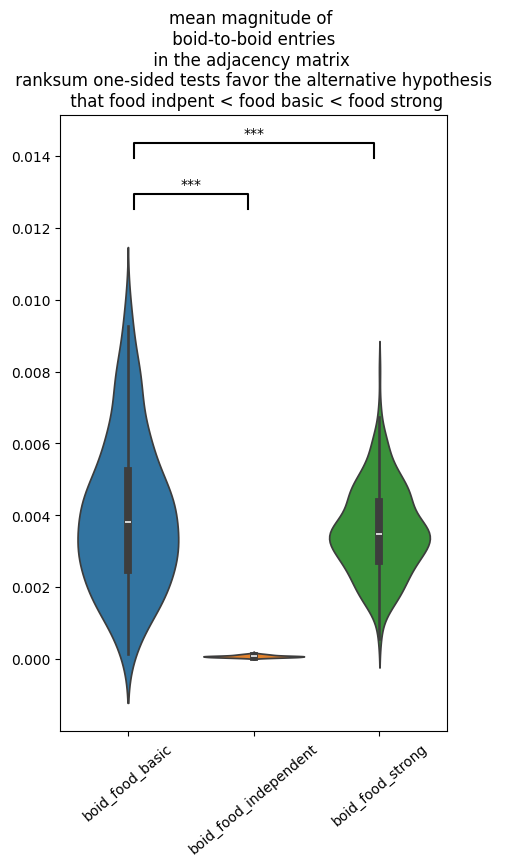

In [60]:
#plt.rcParams["tex"] = True
order = [0,1,2]
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(5, 8))
                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
ax = sns.violinplot(sum_bird_df, ax = axes, palette=my_pal, order = order)
ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)
ax.set_title("mean magnitude of \n boid-to-boid entries \n in the adjacency matrix  \n ranksum one-sided tests favor the alternative hypothesis \n that food indpent < food basic < food strong")

# Annotate significance
annotations = [(0, 1, 0.001), (0, 2, 0.001)]
starbars.draw_annotation(annotations)
plt.savefig(f"food_attention_boid_mean{'_selfloops' if self_loops else ''}{'_rp' if relative_positions else ''}.pdf", bbox_inches="tight")

3.0 0.03
3.0 0.03


/var/folders/1g/7vcyjmld3kn3nfn_nrtskt9r0000gq/T/ipykernel_12930/2337548273.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)


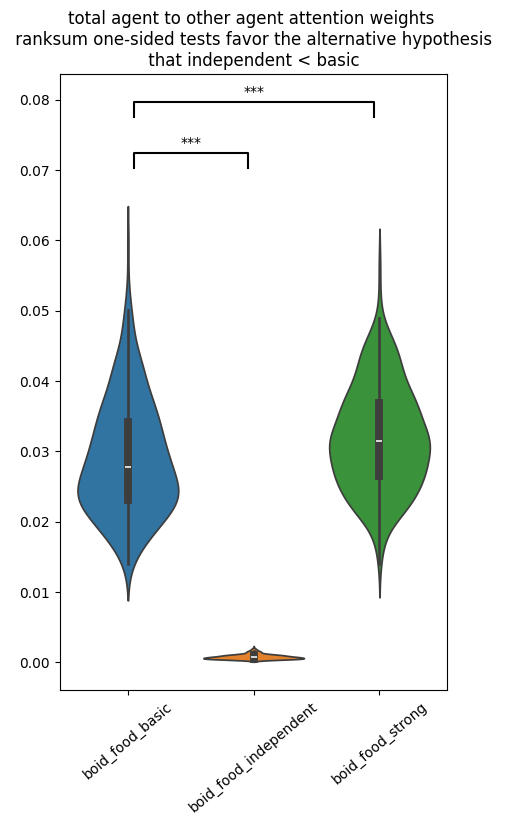

In [59]:
order = range(3)#[0,1,2]
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(5, 8))
                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
ax = sns.violinplot(1 - sum_diag_df, ax = axes, palette=my_pal, order = order)
ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)
ax.set_title("total agent to other agent attention weights \n ranksum one-sided tests favor the alternative hypothesis \n that independent < basic ")

# Annotate significance
annotations = [(0, 1, 0.001), (0, 2, 0.001)]
starbars.draw_annotation(annotations)
plt.savefig(f"food_adj_boid_sum_diag{'_selfloops' if self_loops else ''}{'_rp' if relative_positions else ''}.pdf", bbox_inches="tight")

In [58]:
#new_df = pd.DataFrame({'boid-boid': sum_bird_df[0], 'boid-food': sum_food_df[0]})
#print(new_df.head())
#print('sum bird', sum_bird_df[0].shape)
#print('sum food', sum_food_df[0].shape)
#order = [0,1]

                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
## ax = sns.violinplot({'boid-boid': sum_bird_df[0], 'boid-food': sum_food_df[0]}, ax = axes[0], order = order)
#sns.violinplot(new_df)

/var/folders/1g/7vcyjmld3kn3nfn_nrtskt9r0000gq/T/ipykernel_12930/1323359908.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)


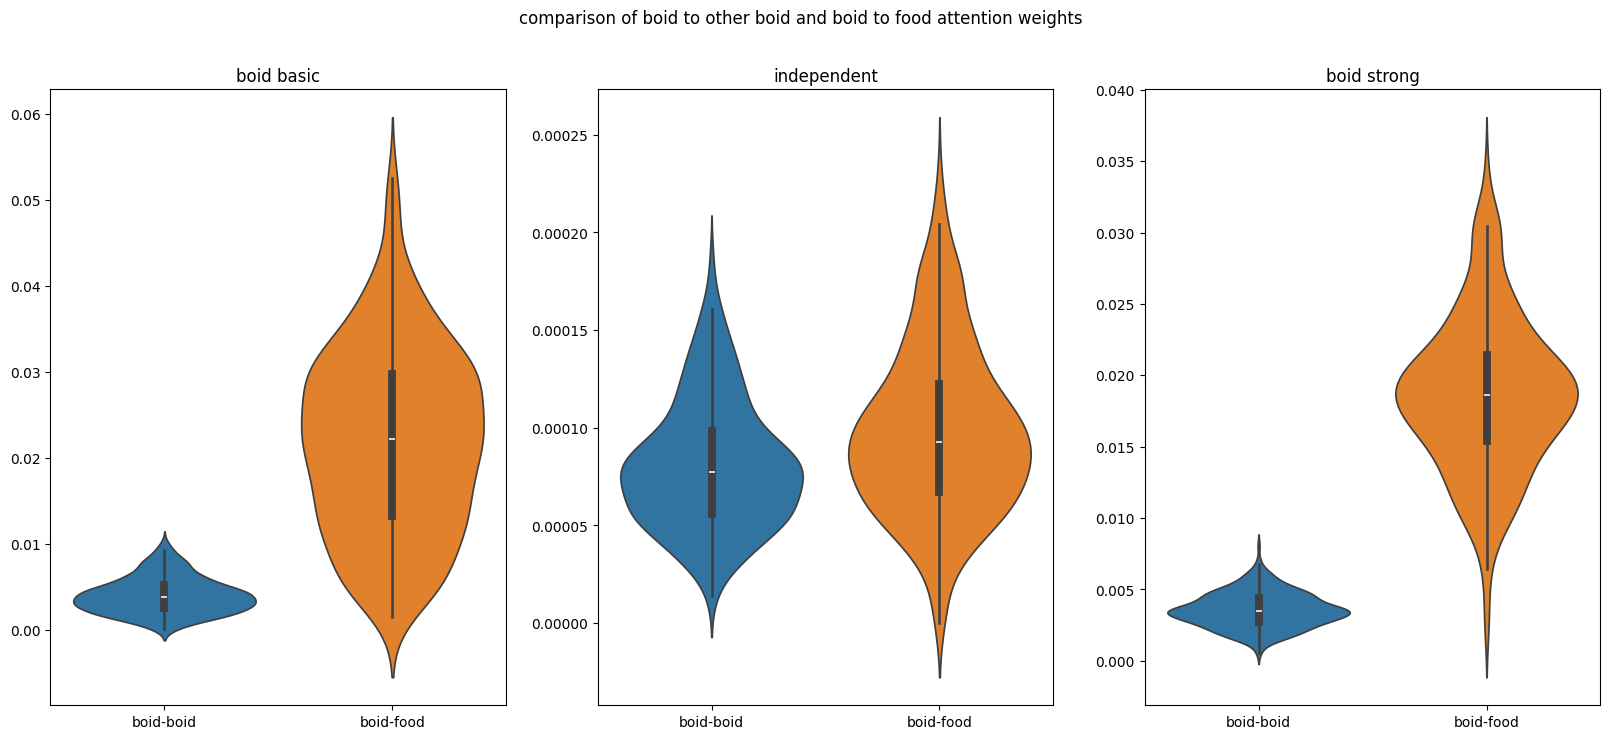

In [54]:
order = range(3)#[0,1,2]
fig, axes = plt.subplots(nrows=1, ncols=3,
                         figsize=(20, 8))
                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
for i in range(3):
    new_df = pd.DataFrame({'boid-boid': sum_bird_df[i], 'boid-food': sum_food_df[i]})
    sns.violinplot(new_df, ax = axes[i])
axes[0].set_title('boid basic')
axes[1].set_title('independent')
axes[2].set_title('boid strong')

ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)
fig.suptitle("comparison of boid to other boid and boid to food attention weights")

plt.savefig(f"boid_to_food_comparison{'_selfloops' if self_loops else ''}{'_rp' if relative_positions else ''}.pdf", bbox_inches="tight")

In [56]:
#new_df = pd.DataFrame({'boid-boid': sum_bird_df[1], 'boid-food': sum_food_df[1]})

                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
## ax = sns.violinplot({'boid-boid': sum_bird_df[0], 'boid-food': sum_food_df[0]}, ax = axes[0], order = order)
#sns.violinplot(new_df)

In [57]:
#new_df = pd.DataFrame({'boid-boid': sum_bird_df[2], 'boid-food': sum_food_df[2]})

                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
## ax = sns.violinplot({'boid-boid': sum_bird_df[0], 'boid-food': sum_food_df[0]}, ax = axes[0], order = order)
#sns.violinplot(new_df)

### Boid to food

In [64]:
_, pvalue01 = ranksums(sum_food_df[0], sum_food_df[1],'greater',nan_policy = 'omit')
_, pvalue02 = ranksums(sum_food_df[0], sum_food_df[2],'greater',nan_policy = 'omit')
_, pvalue03 = ranksums(sum_food_df[1], sum_food_df[2],'less',nan_policy = 'omit')
print(pvalue01, pvalue02, pvalue03)

1.6949029943100063e-96 2.4652827285420616e-05 1.0789335241970174e-97


3.0 0.03
3.0 0.03


/var/folders/1g/7vcyjmld3kn3nfn_nrtskt9r0000gq/T/ipykernel_12930/3995901177.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)


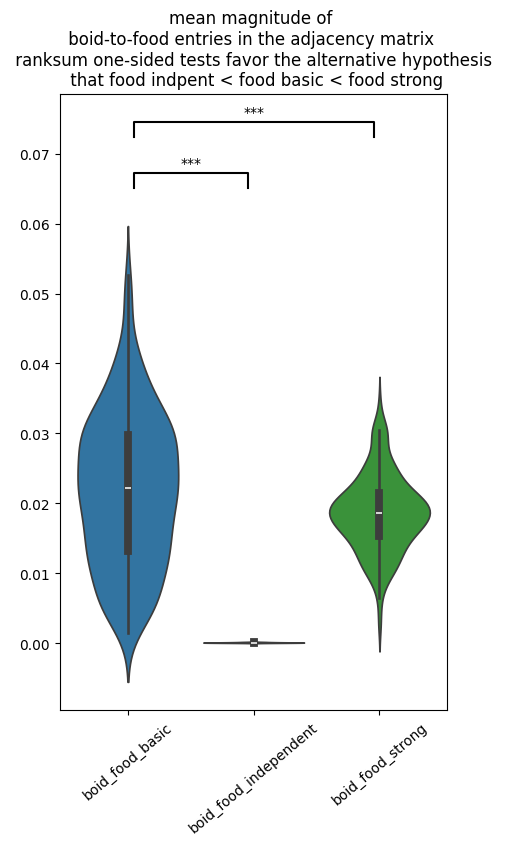

In [61]:
order = [0,1,2]
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(5, 8))
                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
ax = sns.violinplot(sum_food_df, ax = axes, palette=my_pal, order = order)
ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)
ax.set_title("mean magnitude of \n boid-to-food entries in the adjacency matrix  \n ranksum one-sided tests favor the alternative hypothesis \n that food indpent < food basic < food strong")

# Annotate significance
annotations = [(0, 1, 0.001), (0, 2, 0.001)]
starbars.draw_annotation(annotations)
plt.savefig("food_adj_food_sum{'_selfloops' if self_loops else ''}.pdf", bbox_inches="tight")
